# Virtual Branch Correlation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import vbranch as vb
from vbranch.utils.training_utils import get_data
from vbranch.utils.test_utils import compute_acc
from experiments.classification.baseline import _model_path
from experiments.classification.vbranch import _model_path as _vb_model_path

In [3]:
arch = 'fcn'
dataset = 'mnist'
n_classes = 10
n_features = None
samples_per_class = None

In [4]:
_, (X_test, y_test) = get_data(dataset, arch, n_classes, n_features, samples_per_class, one_hot=False)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, n_classes)

## Baseline

In [5]:
model_id_list = range(1, 9)
output_list = []
acc_list = []
pred_list = []

In [6]:
for model_id in model_id_list:
    tf.reset_default_graph()

    with tf.Session() as sess:
        model_path = _model_path(dataset, arch, n_classes, samples_per_class, model_id)
        meta_path = os.path.join(model_path, 'ckpt.meta')
        ckpt = tf.train.get_checkpoint_state(model_path)

        imported_graph = tf.train.import_meta_graph(meta_path)
        imported_graph.restore(sess, ckpt.model_checkpoint_path)

        output = sess.run('model_{}_1/output:0'.format(model_id),
            feed_dict={'x_test:0':X_test})

    # Compute accuracy outside of the graph
    acc = compute_acc(output, y_test_one_hot, n_classes)
    pred = np.argmax(output, axis=1)

    output_list.append(output)
    acc_list.append(acc)
    pred_list.append(pred)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_5/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_6/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_7/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn/model_8/ckpt


In [7]:
acc_list

[0.9413, 0.9482, 0.9472, 0.9429, 0.9455, 0.9448, 0.9434, 0.9454]

In [10]:
def j_hat(preds_per_model, labels, n_classes):
    """
    preds: [samples, n_models]
    Y: 1-D array
    n_classes: scalar
    """
    
    hits_per_class = []
    total = len(pred)
    
    for i in range(n_classes):
        hits = np.sum(preds_per_model == i, axis=1)
        hits_per_class.append(hits)
    
    hits_per_class = np.array(hits_per_class).transpose(1,0)
    # return hits_per_class
    
    hits_per_class[range(labels.shape[0]), labels] = -1
    
    j_hat_list = np.argmax(hits_per_class, axis=1)
    return j_hat_list

def rmg(preds, labels, j):
    """Raw margin function"""
    
    result = (preds == labels).astype('int8') - (preds == j).astype('int8')
    return result

def margin(preds_per_model, labels, j):
    hit = (preds_per_model == labels).astype('int8')
    miss = (preds_per_model == j).astype('int8')
    result_per_model = hit - miss
    return np.mean(result_per_model, axis=1)

In [11]:
def compute_correlation_strength(preds, labels, n_classes, n_models):
    j_list = j_hat(preds, labels, n_classes)

    rmg_list = []
    for i in range(n_models):
        rmg_list.append(rmg(preds[:, i], labels, j_list))

    std_list = [np.std(x) for x in rmg_list]

    num_list = []
    dem_list = []

    for i in range(n_models):
        for j in range(i+1, n_models):
            rho = np.corrcoef(rmg_list[0], rmg_list[1])[0,1]
            num_list.append(rho * std_list[i] * std_list[j])
            dem_list.append(std_list[i] * std_list[j])

    mean_correlation = np.mean(num_list) / np.mean(dem_list)

    strength_list = margin(preds, np.tile(labels[:, np.newaxis], [1,n_models]), 
                           np.tile(j_list[:, np.newaxis], [1,n_models]))
    strength = np.mean(strength_list)

    return mean_correlation, strength

In [26]:
baseline_mean_correlation, baseline_strength = compute_correlation_strength(np.array(pred_list).transpose(1,0), 
                                                                            y_test, n_classes, len(model_id_list))

print('Mean correlation:', baseline_mean_correlation)
print('Strength:' , baseline_strength)

Mean correlation: 0.6910488884916635
Strength: 0.893675


## Virtual Branching

In [16]:
n_branches = 4
# shared = 0.25
# model_id = 3
shared_frac_list = [0, 0.25, 0.5, 0.75, 1]

shared_correlation_list = []
shared_strength_list = []

for shared in shared_frac_list:
    mean_correlation_list = []
    strength_list = []
    
    for model_id in range(1, 5):
        model_path = _vb_model_path(dataset, arch, n_branches, shared, n_classes, 
                                 samples_per_class, model_id)

        tensors = []
        for i in range(n_branches):
            if shared == 0:
                t = 'model_{}_1/output_vb{}:0'.format(model_id, i+1)
            else:
                t = 'model_{}_1/output_{}:0'.format(model_id, i+1)
            tensors.append(t)

        tf.reset_default_graph()

        with tf.Session() as sess:
            meta_path = os.path.join(model_path, 'ckpt.meta')
            ckpt = tf.train.get_checkpoint_state(model_path)

            imported_graph = tf.train.import_meta_graph(meta_path)
            imported_graph.restore(sess, ckpt.model_checkpoint_path)

            outputs, acc = sess.run([tensors, 'acc_ensemble_1:0'], 
                                    feed_dict={'x_test:0': X_test, 'y_test:0': y_test_one_hot})
            
        preds = np.array([np.argmax(x, axis=1) for x in outputs]).transpose(1,0)
        mean_correlation, strength = compute_correlation_strength(preds, y_test, n_classes, n_branches)
        
        mean_correlation_list.append(mean_correlation)
        strength_list.append(strength)
        
    shared_correlation_list.append([np.mean(mean_correlation_list), np.std(mean_correlation_list)])
    shared_strength_list.append([np.mean(strength_list), np.std(strength_list)])

INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn/B4/S0.50/model

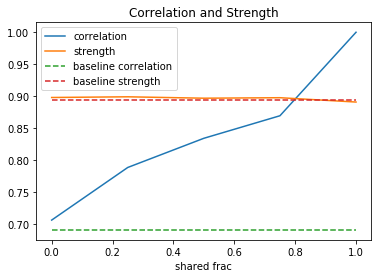

In [29]:
plt.plot(shared_frac_list, np.array(shared_correlation_list)[:, 0], label='correlation')
plt.plot(shared_frac_list, np.array(shared_strength_list)[:, 0], label='strength')

# Baseline
plt.plot(shared_frac_list, [baseline_mean_correlation]* len(shared_correlation_list), 
         label='baseline correlation', linestyle='--')
plt.plot(shared_frac_list, [baseline_strength]* len(shared_correlation_list), 
         label='baseline strength', linestyle='--')

plt.xlabel('shared frac')
plt.title('Correlation and Strength')
plt.legend()

plt.savefig('figs/correlation-strength.png')
plt.show()

In [19]:
shared_correlation_list

[[0.7064012186242554, 0.020002428287257745],
 [0.7886629934331995, 0.011528400118573725],
 [0.8342556489733971, 0.016616243448574698],
 [0.8694823746863698, 0.019182305745519858],
 [1.0, 0.0]]

In [30]:
shared_strength_list

[[0.898025, 0.0014655417087207213],
 [0.8991, 0.0006232475431158825],
 [0.89690625, 0.002450406535148805],
 [0.8976875000000001, 0.0009922354811232996],
 [0.8908999999999999, 0.0016583123951776798]]